# Assignment 1 - Outlier Detection

*Due: Friday, 1 December, 2023 at 14:00 CET*

For the first assignment of the course Applications of Machine Learning (INFOB3APML), you will learn to use decision tree, random forest, and isolation forest to detect an outlier class. The objectives of this assignment are:
- use the supervised classification algorithms to classify outliers in real-life data sets
- perform cross validation and fine-tune the model parameters of each algorithm
- use the unsupervised outlier detection algorithms to detect outliers in real-life data sets
- calculate model performance (e.g., accuracy, recall, precision, f1)
- design experiments to compare performance of algorithms
- reflect on the difference between different models


This assignment includes three algorithms: DT, RF, and IF. The first task is to perform data exploration. In Task 2-4, you will use the three algorithms to classify outliers, respectively. In Task 5, you will compare the algorithms and evaluate their results. Please note that Task 2-4 have the following structure:
1. First, find the library (e.g., sklearn examples) and try out the algorithm by simply training the model on the training data (do not consider any parameters or cross validation just yet);
2. Train the model with the training data by using cross validation and find the best parameter setting for the parameters of interest;
3. Report the average validation accuracy, recall, precision, and F1 scores of all validation sets;
4. Finally, test the optimal model that has the best fitting parameters on your (held-out) test data, and report the test accuracy, precision, recall, and F1.

Note that, in Task 5, you will need all the calculated accuracy, precision, recall and F1 measures from previous tasks. Make sure you save these to a list or dictionary so you can easily evaluate and compare the results.




## Task 1: Exploring the data set



### Data set: Bank Marketing


Import the file *dataBank-additional-full_normalised.csv* to load the preprocessed data set. "*The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.*"


Use the column "label" as the response variable. The instances labeled with 1 are the "outliers", in this case the class we would like to detect accurately; the instance labeled with 0 are the inliers.


The original data description can be found via the link here below. You will also find some explanations regarding the features under the section "Attribute Information".  
https://archive.ics.uci.edu/ml/datasets/bank+marketing





In [36]:
# Import packages
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import plot_tree

# Set constants
RANDOM_SEED = 42


# Import data
data = pd.read_csv("../data/dataBank-additional-full_normalised_sampled.csv", sep=",")
print(f"Data size: {data.memory_usage().sum() / 1e6:.2f} MB")
data.head()

Data size: 20.25 MB


,age,job=housemaid,job=services,job=admin.,job=blue-collar,job=technician,job=retired,job=management,job=unemployed,job=self-employed,...,previous,poutcome=nonexistent,poutcome=failure,poutcome=success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,class
0,0.209877,0,0,0,0,0,0,0,0,0,...,0.000000,1,0,0,1.000000,0.882307,0.376569,0.980730,1.000000,0
1,0.296296,0,0,1,0,0,0,0,0,0,...,0.000000,1,0,0,1.000000,0.484412,0.615063,0.981183,1.000000,0
2,0.246914,1,0,0,0,0,0,0,0,0,...,0.000000,1,0,0,0.937500,0.698753,0.602510,0.957379,0.859735,0
3,0.160494,0,1,0,0,0,0,0,0,0,...,0.142857,0,1,0,0.333333,0.269680,0.192469,0.150759,0.512287,0
4,0.530864,0,0,0,1,0,0,0,0,0,...,0.000000,1,0,0,0.333333,0.340608,0.154812,0.174790,0.512287,1



### 1.1. Exploratory data analysis

For the data set, create 2-3 figures and tables that will help you understand the data.


During the data exploration, you, as a team, are trying to get an impression about the data. You will create figures and/or tables that help you to get to know the data. While exploring the data, you may also consider answering the following questions, which may help you understand the data better. For example,

- How many instances are there in each class? Are the classes imbalanced?
- How many variables are in the data? What is the data type and the distribution of each variable?
- Are the variables informative?
- Are any pair of the potential predictor variables highly correlated?
- (Should the variables be normalized or not?)
- (Any relevant, useful preprocessing steps that may be taken?)

#### Tips:

Make sure to at least check the data type of each variable and to understand the distribution of each variable, especially the response variable.

Try to find out what factors seem to determine whether an instance is an outlier or not. What do you conclude?

*For creating data visualizations, you may consider using the matplot library and visit the [matplot gallery](https://matplotlib.org/stable/gallery/index.html) for inspiration (e.g., histograms for distribution, or heatmaps for feature correlation).*



#### Overview of the Data

In [37]:
categorical_columns = [col for col in data.columns if "=" in col]

categories = defaultdict(list)
for col in categorical_columns:
    category, value = col.split("=")
    categories[category].append(value)
numeric_columns = [col for col in data.columns if col not in categorical_columns]

print("Categorical Variables")
pd.DataFrame(
    pd.Series(categories, name="Allowed Values").rename_axis("Categorical Variable")
)

Categorical Variables


,Allowed Values
Categorical Variable,
job,"[housemaid, services, admin., blue-collar, tec..."
marital,"[married, single, divorced, unknown]"
education,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
default,"[0, unknown, 1]"
housing,"[0, 1, unknown]"
loan,"[0, 1, unknown]"
contact,[cellular]
month,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."
day_of_week,"[mon, tue, wed, thu, fri]"


In [38]:
print("Overview of Numeric Variables")
data[numeric_columns].describe()

Overview of Numeric Variables


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,class
count,40188.000000,40188.000000,40188.000000,40188.000000,40188.000000,40188.000000,40188.000000,40188.000000,40188.000000,40188.000000,40188.000000
mean,0.284092,0.051847,0.028610,0.965300,0.024119,0.728616,0.536740,0.430275,0.681292,0.772429,0.103016
std,0.127940,0.051967,0.050590,0.182451,0.069609,0.325611,0.224757,0.192595,0.391320,0.270591,0.303983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.185185,0.020740,0.000000,1.000000,0.000000,0.333333,0.340608,0.338912,0.160961,0.512287,0.000000
50%,0.259259,0.036194,0.018182,1.000000,0.000000,0.937500,0.603274,0.376569,0.957379,0.859735,0.000000
75%,0.370370,0.064050,0.036364,1.000000,0.000000,1.000000,0.698753,0.602510,0.980957,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Figures

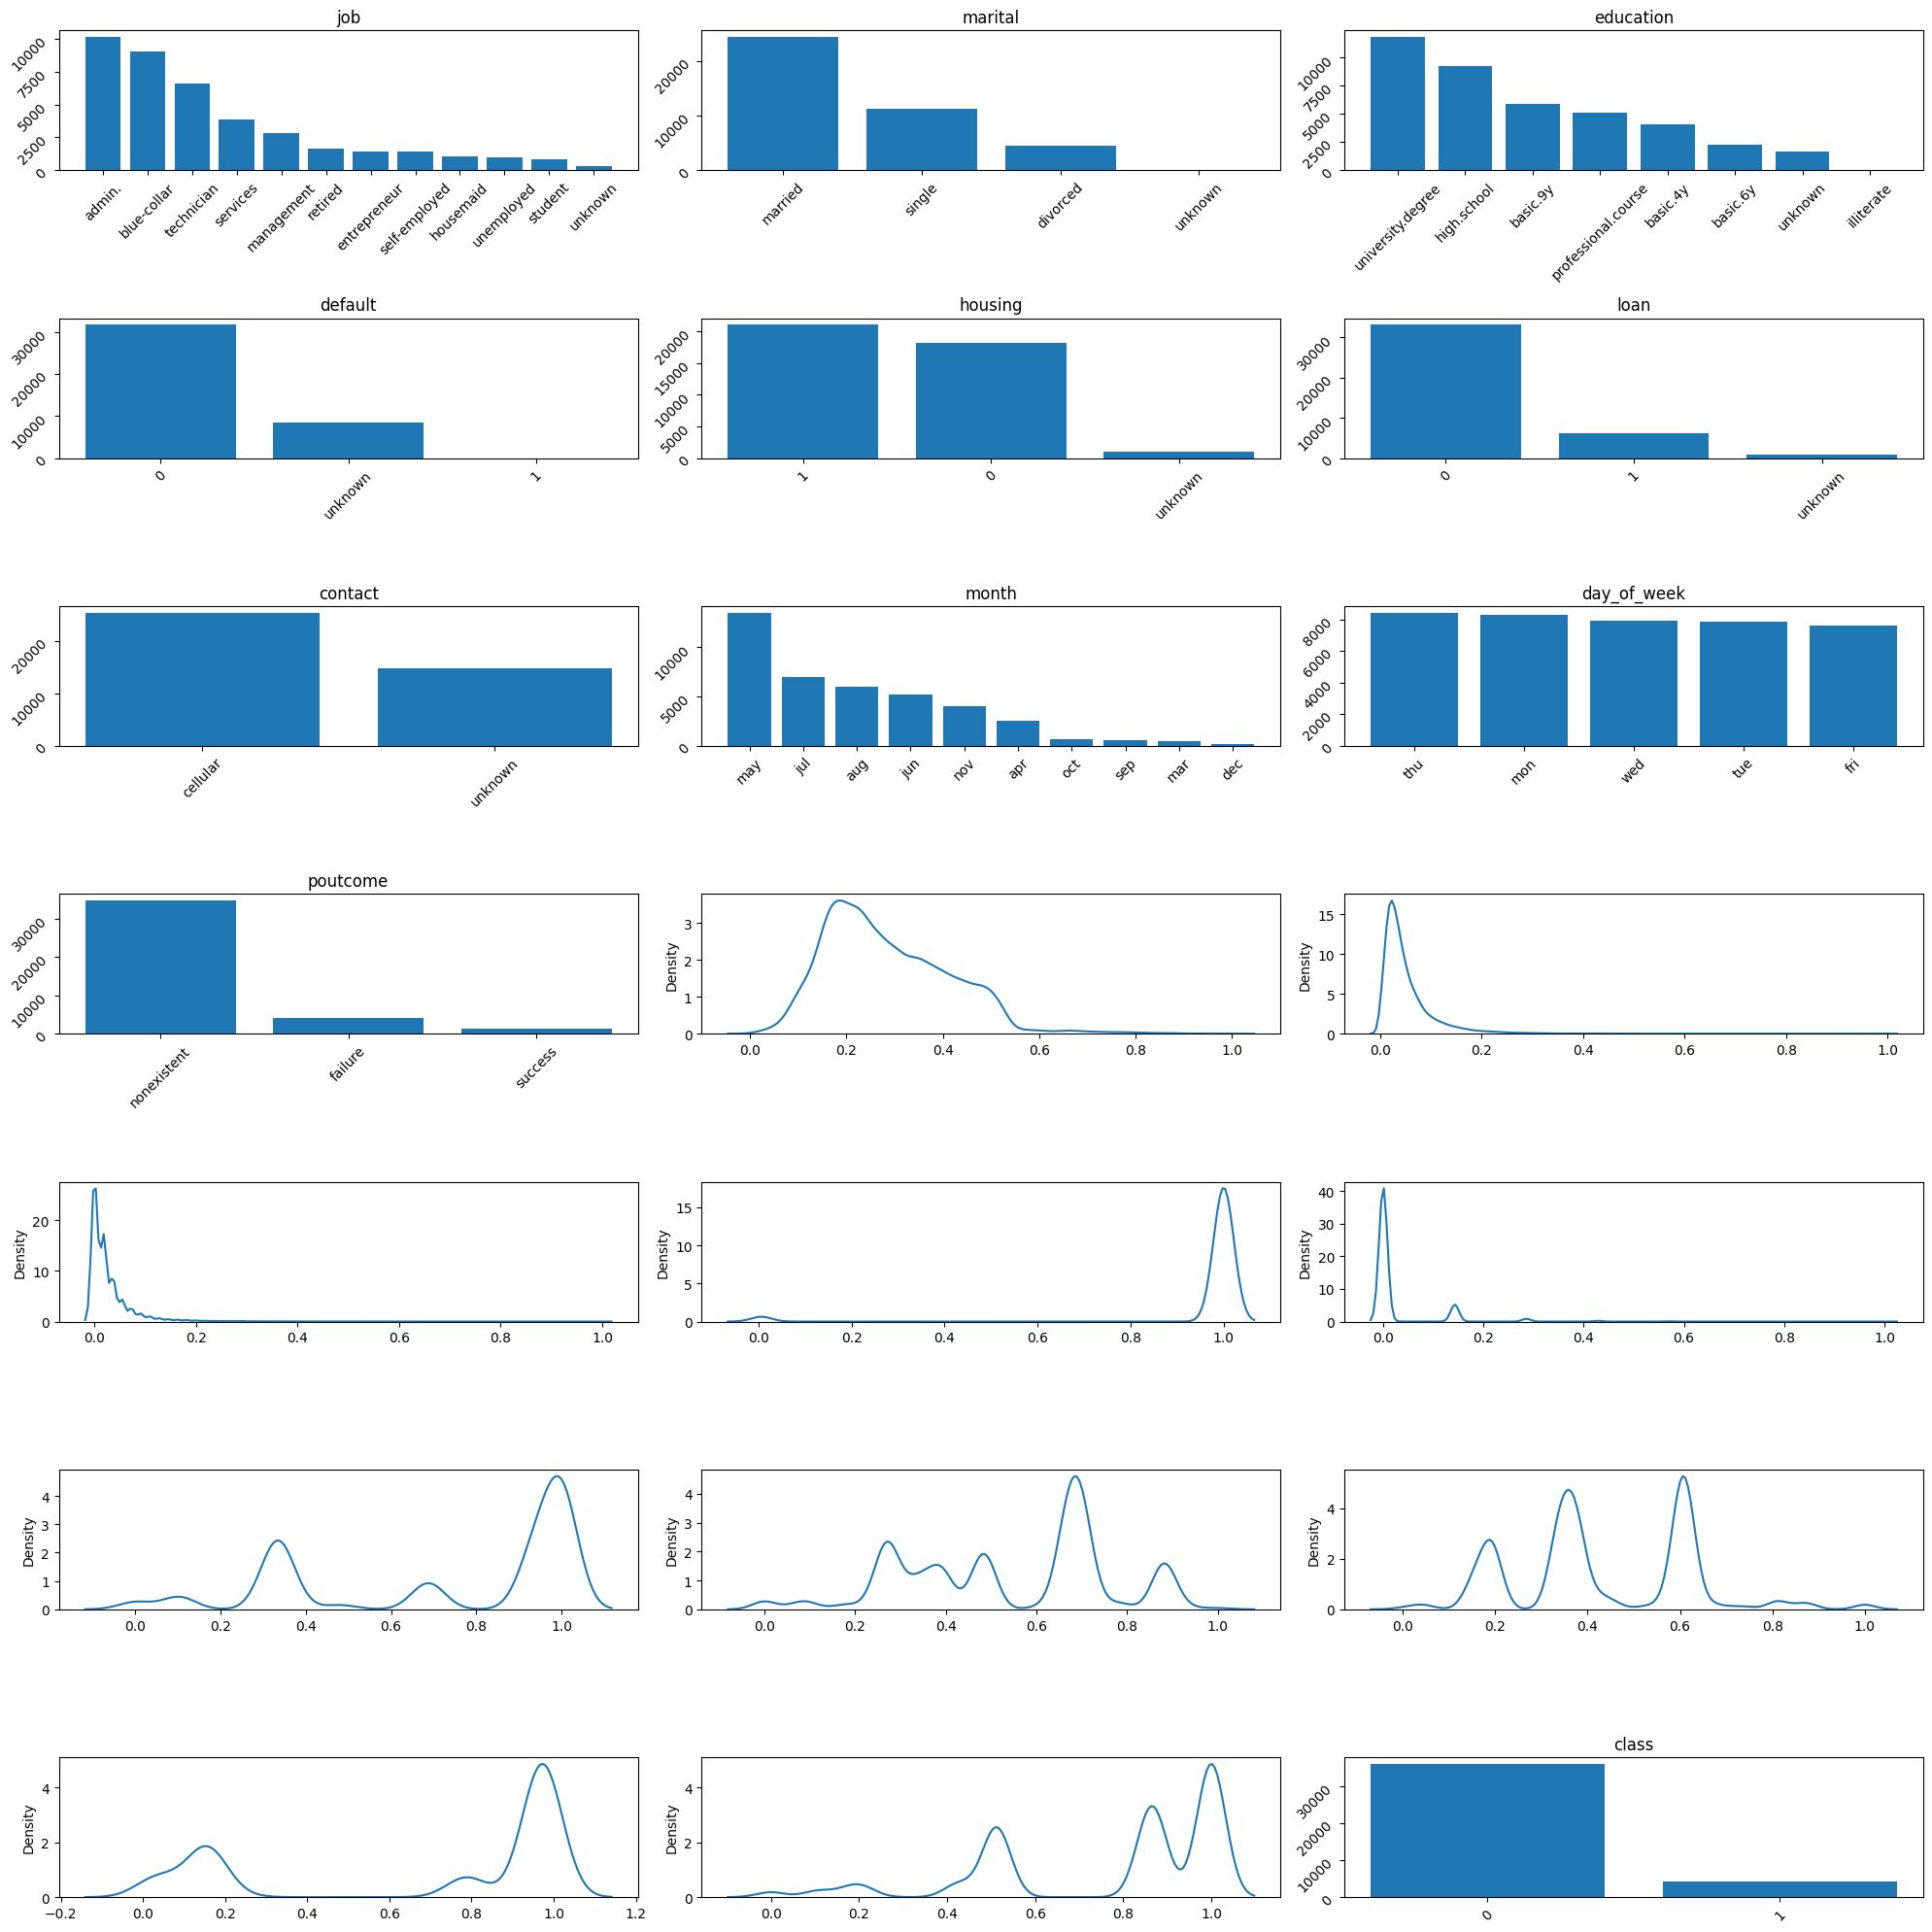

In [39]:
def decode_category(row, prefix):
    for column in row.index:
        if column.startswith(prefix) and row[column] == 1:
            return column.split("=")[1]


categorical_data = data.copy(deep=True)
for category in categories:
    categorical_data[category] = categorical_data.apply(
        decode_category, axis=1, args=(category,)
    )
categorical_data = categorical_data.drop(
    columns=numeric_columns + categorical_columns
).replace({None: "unknown"})

one_hot_decoded_data = pd.concat([categorical_data, data[numeric_columns]], axis=1)

fig, axes = plt.subplots(7, 3, figsize=(20, 20))
flattened_axes = axes.flatten()
for col, ax in zip(one_hot_decoded_data.columns, flattened_axes):
    counts = one_hot_decoded_data[col].value_counts()
    if col in categories or data[col].dtype is np.dtype('int'):
        ax.bar(counts.index.map(str), counts.values)
        ax.tick_params(labelrotation=45)
        ax.set_title(col)
    elif col in numeric_columns:
        sns.kdeplot(data=data[col].to_numpy(), ax=ax)
fig.tight_layout()
plt.show()


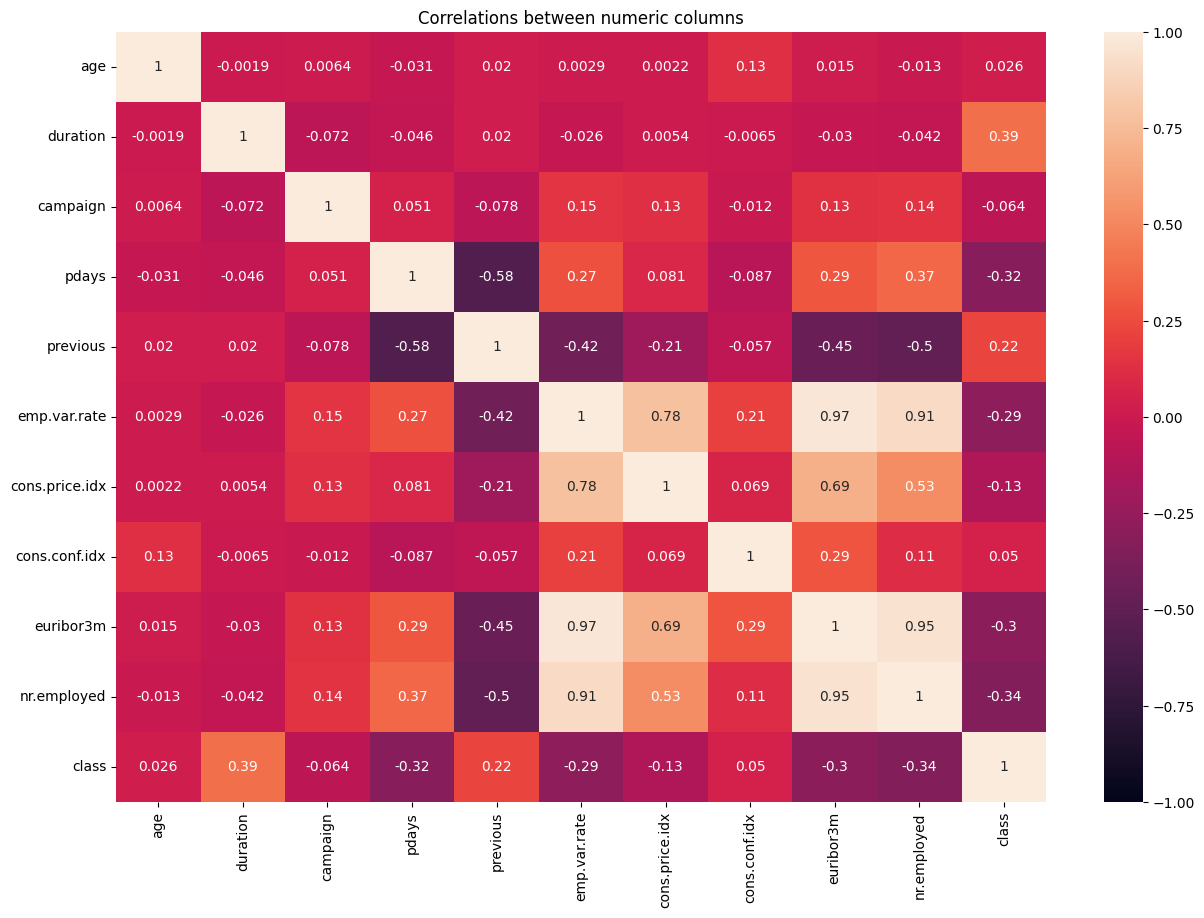

In [40]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(data[numeric_columns].corr(), annot=True, vmin=-1, vmax=1)
plt.title("Correlations between numeric columns")
plt.show()

### 1.2. Creating Train and Test data sets

Create a training and a held-out test data set. *Later in Task 2-4, the training data will be used to perform cross-validation. The held-out test data will be used to evaluate the performance of the selected models.*

Choose the size of your test data and motivate your choice when you discuss the experiment setup in your report.

Tips:

*You may use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) class provided by sklearn*

In [41]:
# copy data
df = data.copy()

# create X and y
features = ["age", "job=housemaid", "job=services", "job=admin.", "job=blue-collar",
       "job=technician", "job=retired", "job=management", "job=unemployed",
       "job=self-employed", "job=unknown", "job=entrepreneur", "job=student",
       "marital=married", "marital=single", "marital=divorced",
       "marital=unknown", "education=basic.4y", "education=high.school",
       "education=basic.6y", "education=basic.9y",
       "education=professional.course", "education=unknown",
       "education=university.degree", "education=illiterate", "default=0",
       "default=unknown", "default=1", "housing=0", "housing=1",
       "housing=unknown", "loan=0", "loan=1", "loan=unknown",
       "contact=cellular", "month=may", "month=jun", "month=jul", "month=aug",
       "month=oct", "month=nov", "month=dec", "month=mar", "month=apr",
       "month=sep", "day_of_week=mon", "day_of_week=tue", "day_of_week=wed",
       "day_of_week=thu", "day_of_week=fri", "duration", "campaign", "pdays",
       "previous", "poutcome=nonexistent", "poutcome=failure",
       "poutcome=success", "emp.var.rate", "cons.price.idx", "cons.conf.idx",
       "euribor3m", "nr.employed"]
# feature selection: remove duration as it highly affects the output 
# target but is not known before a call is performed
filtered_features = [f for f in features if f != 'duration']
X = df[filtered_features]
y = df[["class"]]

# TODO: create training data and held-out test data
X_, X_heldout, y_, y_heldout = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

## Task 2: Decision Trees
### - Outlier Detection as a Supervised Classification

### 2.1 Training a Decision Tree

Use the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn to learn a decision tree model by fitting the full training data.

Show/plot the tree diagram and also plot the feature importances.
What do you observe?


#### Tips:

To show the tree diagram, you may use the graphviz library or use the plot_tree function, see https://scikit-learn.org/stable/modules/tree.html




In [7]:
# TODO: learn a decision tree using default parameters
cl = tree.DecisionTreeClassifier()
cl.fit(X_, y_);

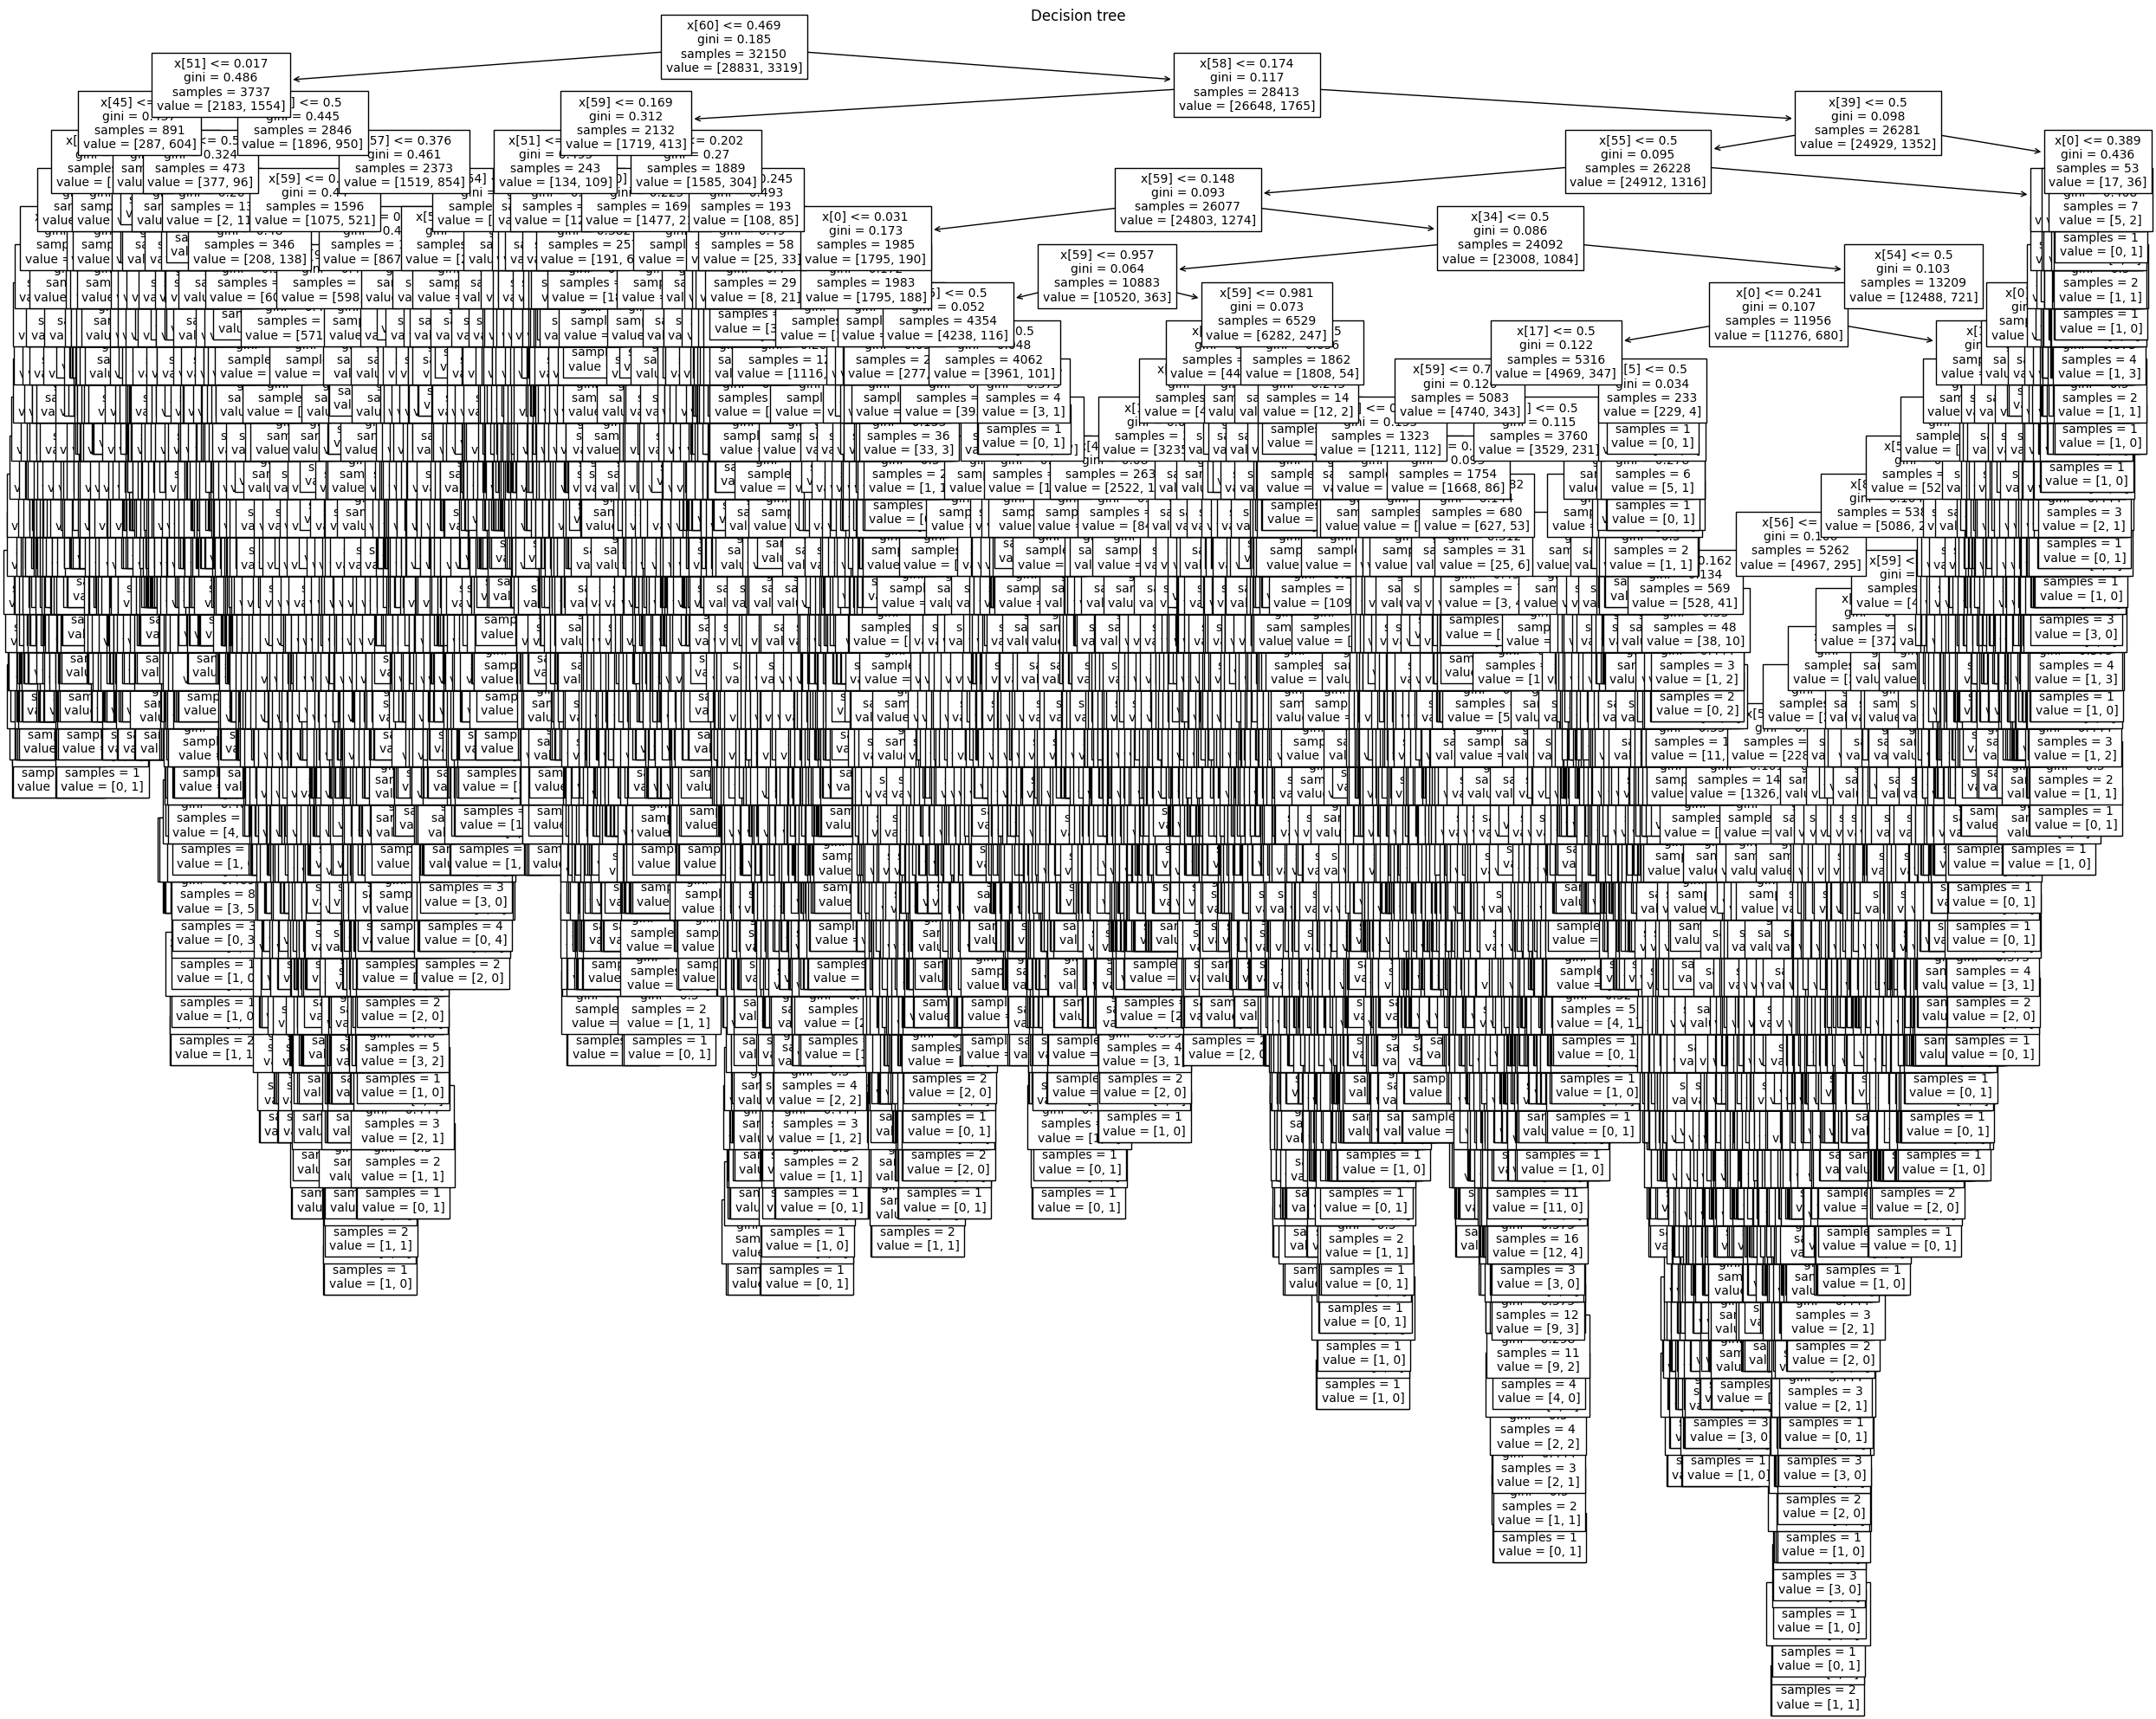

In [8]:
# TODO: plot the tree
def plot_tree_custom_size(classifier, figsize=(25, 20), fontsize=10):
    fig, ax = plt.subplots(figsize=figsize)
    plot_tree(classifier, fontsize=fontsize, ax=ax)
    ax.set_title("Decision tree")
    fig.tight_layout()

plot_tree_custom_size(cl)

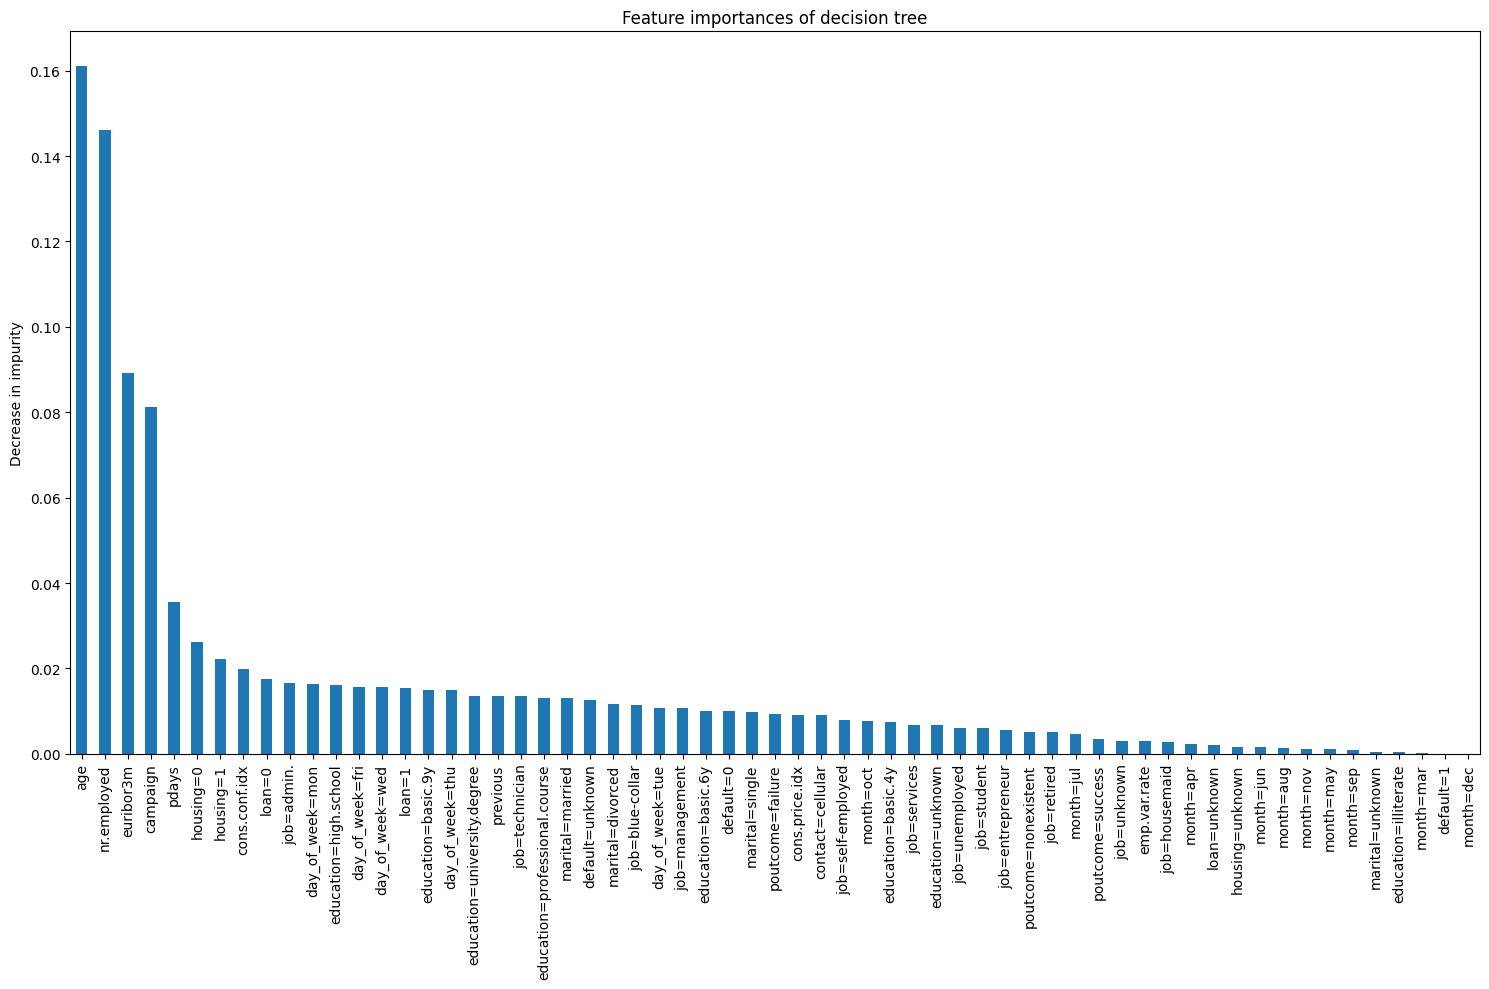

In [9]:
# TODO: plot the feature importances

def plot_feature_importance(classifier, features):
    feature_importance = pd.Series(
        classifier.feature_importances_, index=features
    ).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(15, 10))
    feature_importance.plot.bar(ax=ax)
    ax.set_title("Feature importances of decision tree")
    ax.set_ylabel("Decrease in impurity")
    fig.tight_layout()

plot_feature_importance(cl, filtered_features)

### 2.2 Confusion Matrix and Accuracy

Compute the *confusion matrix* and *accuracy* of the tree using the held-out data set. Moreover, also compute the *recall*, *precision*, and *F1-score* of the tree.


For this part, you can either implement your own functions or use the following scikit-learn libraries.  
- [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
- [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
- [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
- [f1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
- [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)


Reflect on the performance of the model and be aware of the difference between *accuracy* and *F1-score*. How good is this decision tree model for outlier detection?

In [10]:
# use the model to make predictions for the test data set
y_pred = cl.predict(X_heldout)

# TODO: compute accuracy, recall, precision, and f1 score


def print_performance_metrics(y_true, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred), "\n")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2}")
    print(f"Recall: {recall_score(y_true, y_pred):.2}")
    print(f"Precision: {precision_score(y_true, y_pred):.2}")
    print(f"F1: {f1_score(y_true, y_pred):.2}")


print_performance_metrics(y_heldout, y_pred)

Confusion Matrix:
 [[6574  643]
 [ 542  279]] 

Accuracy: 0.85
Recall: 0.34
Precision: 0.3
F1: 0.32


### 2.3 Features to Tree  (optional)

Use the training data to re-fit a new decision tree with the parameter max_depth set to 4. Show the tree diagram and also plot the feature importances.

Recalculate the performance of this simpler model.

What do you observe?


Confusion Matrix:
 [[7141   76]
 [ 652  169]] 

Accuracy: 0.91
Recall: 0.21
Precision: 0.69
F1: 0.32


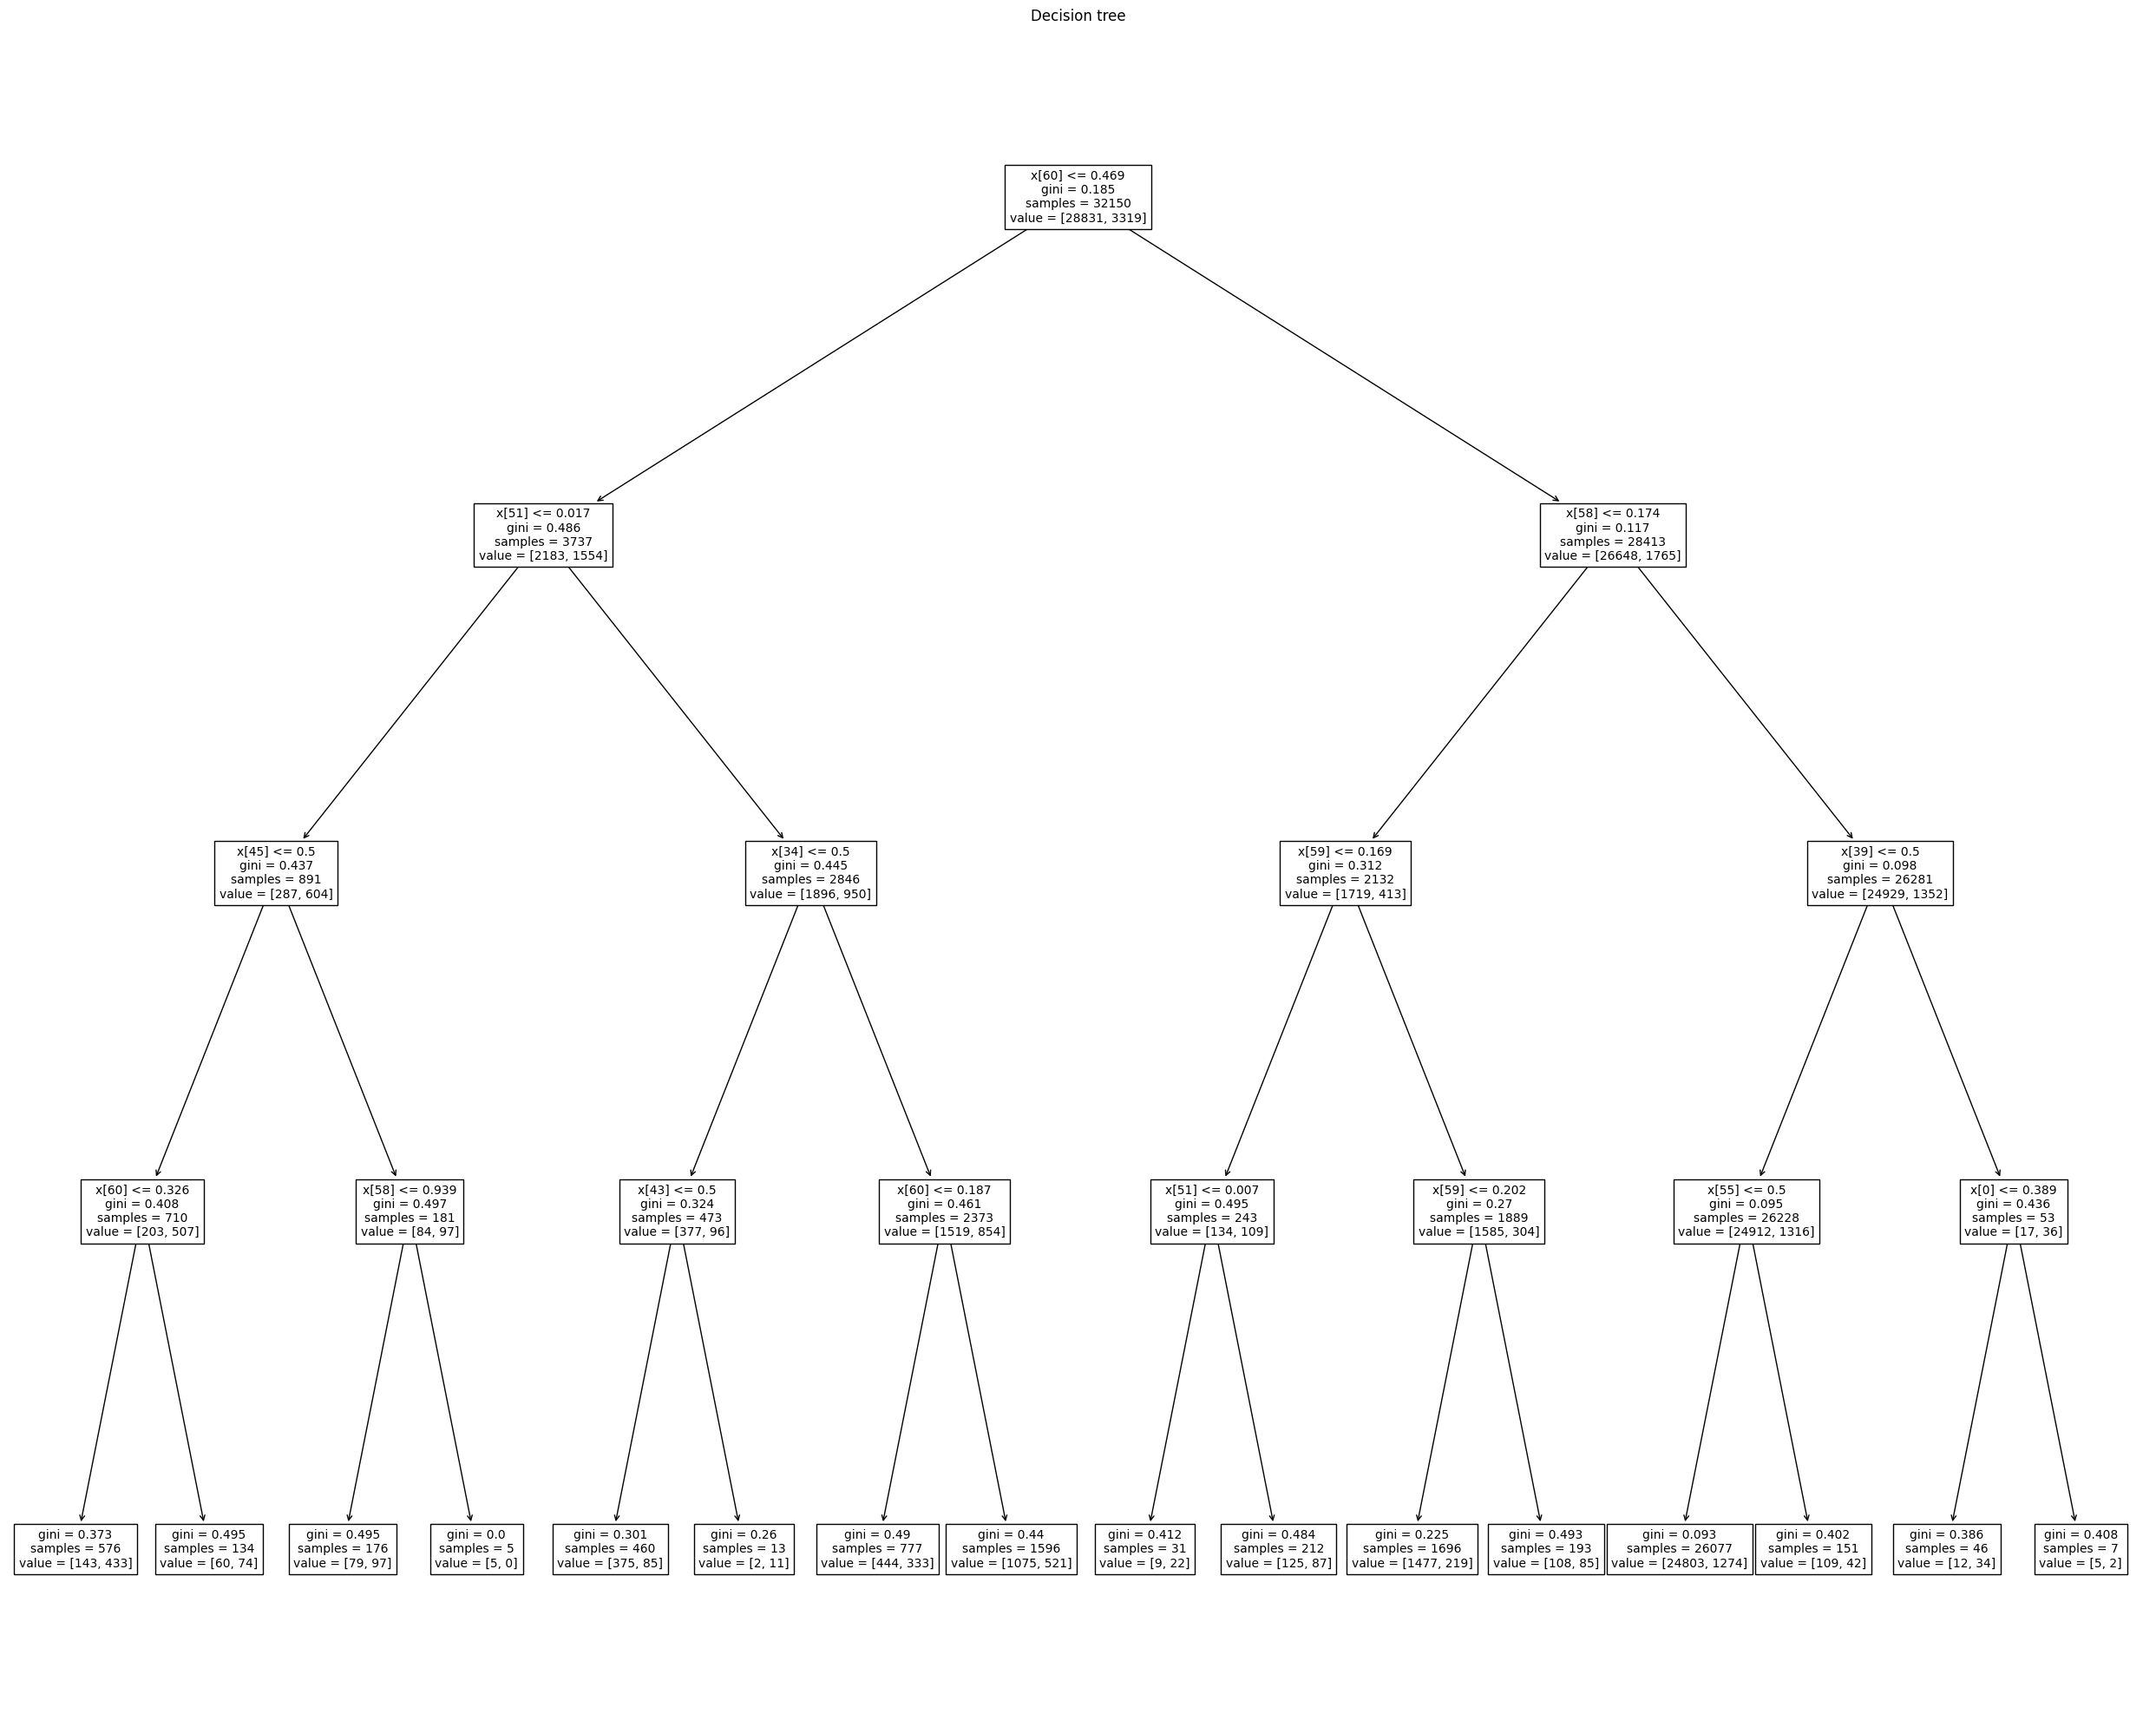

In [11]:
# TODO: learn a decision tree with maximal depth 4
cl_depth_4 = tree.DecisionTreeClassifier(max_depth=4)
cl_depth_4.fit(X_, y_)

# TODO: plot the tree
plot_tree_custom_size(cl_depth_4)

# use the model to make predictions for the test data set
y_pred = cl_depth_4.predict(X_heldout)

# TODO: compute accuracy, recall, precision, and F1 score
print_performance_metrics(y_heldout, y_pred)

### 2.4 Cross validation (optional)

The code example shown here below uses the [kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) method to implement 5-fold cross-validation. Moreover, it uses the cross validation to explore how the max_depth influences the model performance. It keeps track of the validation accuracy scores and F1-scores across the 5 folds.


Now, change the code to also compute the recall and precision.


In [12]:
# create 5-fold cross-validation
nk = 5
kf = KFold(n_splits=nk, random_state=RANDOM_SEED, shuffle=True)

# Search the parameter among the following
params_max_depth = np.arange(2, 10)

# init metrics
accuracy = np.zeros((nk, len(params_max_depth)))
f1 = np.zeros((nk, len(params_max_depth)))
recall = np.zeros((nk, len(params_max_depth)))
precision = np.zeros((nk, len(params_max_depth)))

for i, (train_index, val_index) in enumerate(kf.split(X_)):
    X_t, X_val = X_.iloc[train_index], X_.iloc[val_index]
    y_t, y_val = y_.iloc[train_index], y_.iloc[val_index]
    for j, param_max_depth in enumerate(params_max_depth):
        dt = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=param_max_depth)
        dt.fit(X_t, y_t)
        y_hat = dt.predict(X_val)
        accuracy[i][j] = accuracy_score(y_val, y_hat)
        f1[i][j] = f1_score(y_val, y_hat)
        recall[i][j] = recall_score(y_val, y_hat)
        precision[i][j] = precision_score(y_val, y_hat)


def select_best_model(measure, results):
    mean_results = np.mean(results, axis=0)
    print(f"Mean {measure}:\t{mean_results}")
    best_model_index = np.argmax(mean_results)
    print(f"Selected model index for {measure}:\t{best_model_index}")
    print(f"Selected model {measure} score:\t{mean_results[best_model_index]}\n")
    return best_model_index


select_best_model("accuracy", accuracy)
select_best_model("F1", f1)
select_best_model("recall", recall)
select_best_model("precision", precision);

Mean accuracy:	[0.90615863 0.90662519 0.90684292 0.90653188 0.90600311 0.90426128
 0.90348367 0.90186625]
Selected model index for accuracy:	2
Selected model accuracy score:	0.9068429237947123

Mean F1:	[0.28031482 0.29153491 0.29807597 0.34683486 0.34013628 0.35421639
 0.34166673 0.35560233]
Selected model index for F1:	7
Selected model F1 score:	0.35560232894577715

Mean recall:	[0.17727307 0.18633594 0.19175987 0.24190095 0.23469386 0.25435954
 0.24258328 0.26235118]
Selected model index for recall:	7
Selected model recall score:	0.26235118452661366

Mean precision:	[0.67419061 0.67349047 0.67140457 0.62709253 0.61989685 0.58369046
 0.57838293 0.552067  ]
Selected model index for precision:	0
Selected model precision score:	0.6741906092403719



### 2.5 Tree Tuning



The built-in decision tree algorithm you are using has several parameters which you can tune (e.g., *max_depth* and *min_samples_leaf*). Use 5-fold cross-validation (e.g., reuse the code of task 2.4 and adapt the code for two parameters), show how the choice of these parameters affects performance.


#### Tips:
Make a decision on the range of values that you would try for the two parameters and discuss your choice in the experiment setup section.

Here is a guide that helps you to build the experiment.
First, reuse the code of task 2.4 and show how max_depth affects train and **validation accuracy**. On a single axis, plot train and **validation accuracy** as a function of max_depth. Use a red line to show validation accuracy and a blue line to show train accuracy. (Do not use your (held-out) **test data** yet).

Second, show how validation accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest F1 score? How sensitive are the results to these two parameters?

Finally, select the best-performing decision tree (i.e., the one that achieved the highest cross-validated performance) and report the performance of the fitted model on the held-out test data -- how does it compare to the cross-validated F1 score?


#### Impact of max_depth on train & validation accuracy

In [13]:
# create 5-fold cross-validation
nk = 5
kf = KFold(n_splits=nk, random_state=RANDOM_SEED, shuffle=True)

# Search the parameter among the following
params_max_depth = np.arange(2, 10)

# init metrics
train_accuracy = np.zeros((nk, len(params_max_depth)))
validation_accuracy = np.zeros((nk, len(params_max_depth)))

for i, (train_index, val_index) in enumerate(kf.split(X_)):
    X_t, X_val = X_.iloc[train_index], X_.iloc[val_index]
    y_t, y_val = y_.iloc[train_index], y_.iloc[val_index]
    for j, param_max_depth in enumerate(params_max_depth):
        dt = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=param_max_depth)
        dt.fit(X_t, y_t)
        y_t_hat = dt.predict(X_t)
        y_val_hat = dt.predict(X_val)
        train_accuracy[i][j] = accuracy_score(y_t, y_t_hat)
        validation_accuracy[i][j] = accuracy_score(y_val, y_val_hat)

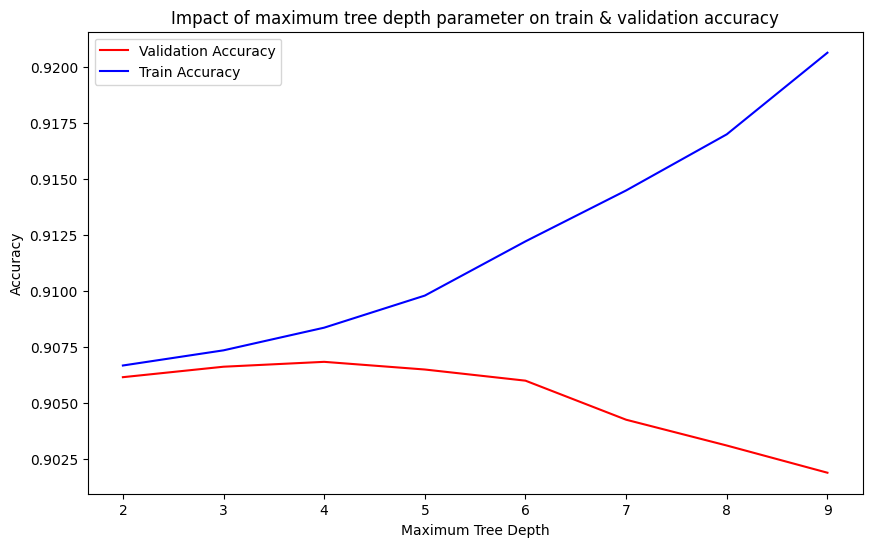

In [14]:
mean_validation_accuracy = np.mean(validation_accuracy, axis=0)
mean_train_accuracy = np.mean(train_accuracy, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(
    params_max_depth, mean_validation_accuracy, label="Validation Accuracy", color="red"
)
plt.plot(params_max_depth, mean_train_accuracy, label="Train Accuracy", color="blue")

# Adding labels and title
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Accuracy")
plt.title("Impact of maximum tree depth parameter on train & validation accuracy")
plt.legend()

# Displaying the plot
plt.show()

#### Impact of max_depth and min_samples_leaf on validation accuracy

In [15]:
# TODO: create 5-fold cross-validation
nk = 5
kf = KFold(n_splits=nk, random_state=RANDOM_SEED, shuffle=True)

# TODO: set the search space of the parameters
max_depth_choices = np.arange(2, 10)
min_samples_leaf_choices = np.arange(1, 14) ** 2

# TODO: learn an optimal decision tree model

param_choices = [
    {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf}
    for max_depth in max_depth_choices
    for min_samples_leaf in min_samples_leaf_choices
]

accuracy = np.zeros((nk, len(param_choices)))
f1 = np.zeros((nk, len(param_choices)))
recall = np.zeros((nk, len(param_choices)))
precision = np.zeros((nk, len(param_choices)))


for i, (train_index, val_index) in enumerate(kf.split(X_)):
    X_t, X_val = X_.iloc[train_index], X_.iloc[val_index]
    y_t, y_val = y_.iloc[train_index], y_.iloc[val_index]
    for j, param in enumerate(param_choices):
        dt = tree.DecisionTreeClassifier(
            min_samples_leaf=param["min_samples_leaf"], max_depth=param["max_depth"]
        )
        dt.fit(X_t, y_t)
        y_hat = dt.predict(X_val)
        accuracy[i][j] = accuracy_score(y_val, y_hat)
        f1[i][j] = f1_score(y_val, y_hat)
        recall[i][j] = recall_score(y_val, y_hat)
        precision[i][j] = precision_score(y_val, y_hat)

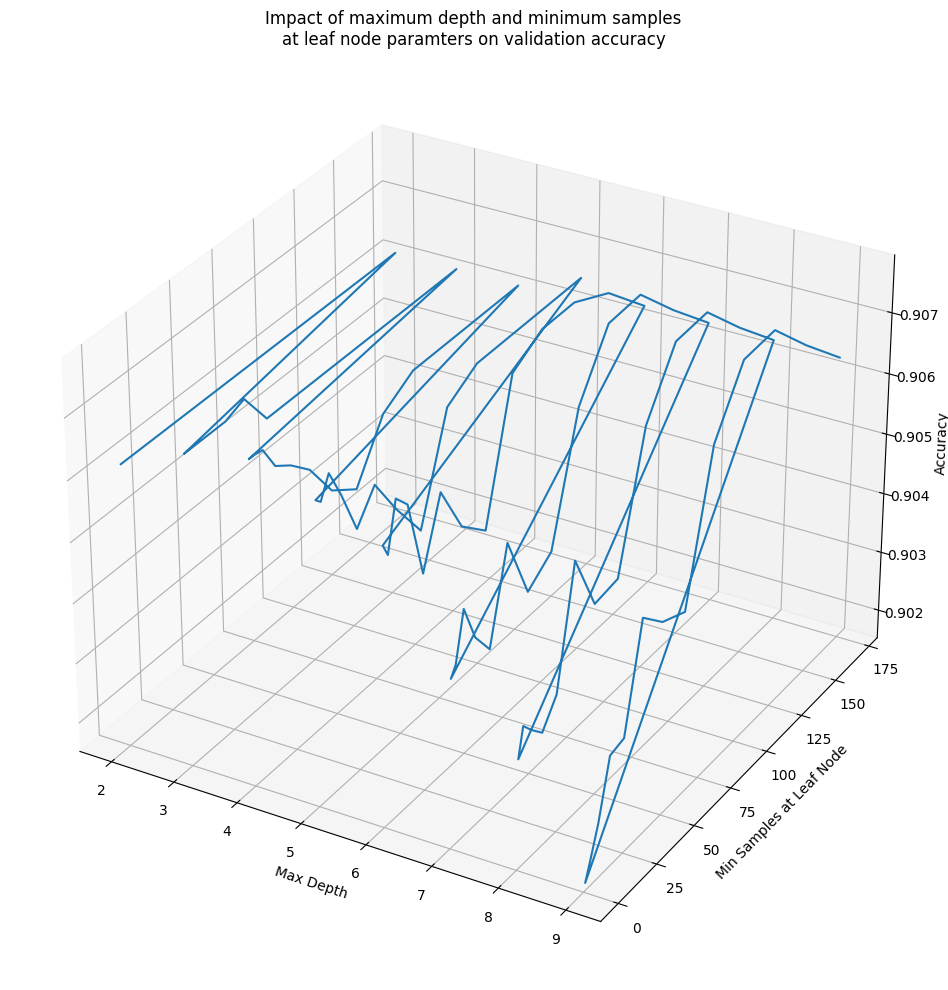

In [16]:
# TODO: create 2D (or 3D) plot that shows how the selected parameters affect the performance.

results = pd.DataFrame(
    [
        param_choice | {"accuracy": accuracy}
        for param_choice, accuracy in zip(param_choices, np.mean(accuracy, axis=0))
    ]
)

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(111, projection="3d")

ax.plot(results.max_depth, results.min_samples_leaf, results.accuracy)

ax.set_xlabel("Max Depth")
ax.set_ylabel("Min Samples at Leaf Node")
ax.set_zlabel("Accuracy")
ax.set_title(
    "Impact of maximum depth and minimum samples\n"
    "at leaf node paramters on validation accuracy"
)
fig.tight_layout()
plt.show()


In [17]:
# TODO: find model with maximum F1 score
best_model = param_choices[np.argmax(np.mean(f1, axis=0))]
print("Selected model for F1:", best_model)

Selected model for F1: {'max_depth': 7, 'min_samples_leaf': 16}


In [18]:
# TODO: compute the performance of the model on your held-out test data

dt = tree.DecisionTreeClassifier(**best_model)
dt.fit(X_, y_)
y_pred = dt.predict(X_heldout)


print_performance_metrics(y_heldout, y_pred)

Confusion Matrix:
 [[7109  108]
 [ 630  191]] 

Accuracy: 0.91
Recall: 0.23
Precision: 0.64
F1: 0.34


## Task 3. Random Forest

### - Outlier Detection as a Supervised Classification

Now use a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict the labels for the data set.

i) use the default values for the parameters to get a RF model running.

ii) use 5-fold cross-validation to determine a possibly better choice for the parameter *n_estimators* and *max_features*

iii) select the best-performing decision tree (i.e., the one that achieved the highest cross-validated performance) and report the performance of the fitted model on the held-out test data ?

In the report, reflect on how does the test performance of RF compare to the decision tree performance?



In [19]:
rf_baseline = RandomForestClassifier(random_state=RANDOM_SEED)
rf_baseline.fit(X_, np.ravel(y_))
rf_baseline_pred = rf_baseline.predict(X_heldout)

print_performance_metrics(y_heldout, rf_baseline_pred)

Confusion Matrix:
 [[7020  197]
 [ 587  234]] 

Accuracy: 0.9
Recall: 0.29
Precision: 0.54
F1: 0.37


In [20]:
# TODO: create 5-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

# TODO: set the search space of the parameters
param_choices = [
    {"max_features": max_f, "n_estimators": num_est}
    for max_f in np.arange(2, 11, 4)
    for num_est in np.arange(20, 141, 60)
]


accuracy = np.zeros((k, len(param_choices)))
f1 = np.zeros((k, len(param_choices)))
recall = np.zeros((k, len(param_choices)))
precision = np.zeros((k, len(param_choices)))

In [21]:
# TODO: learn an optimal random forest model


def train_and_evaluate(classifier, train_index, val_index, param):
    X_t, X_val = X_.iloc[train_index], X_.iloc[val_index]
    y_t, y_val = y_.iloc[train_index], y_.iloc[val_index]
    rf = classifier(**param, random_state=RANDOM_SEED)
    rf.fit(X_t, np.ravel(y_t))
    y_hat = rf.predict(X_val)

    return {
        "accuracy": accuracy_score(y_val, y_hat),
        "f1": f1_score(y_val, y_hat),
        "recall": recall_score(y_val, y_hat),
        "precision": precision_score(y_val, y_hat),
    }


def parallel_k_fold_cross_validation(classifier, param_choices):
    with ThreadPoolExecutor() as executor:
        future_to_params = {
            executor.submit(
                train_and_evaluate, classifier, train_index, val_index, param
            ): (i, j)
            for i, (train_index, val_index) in enumerate(kf.split(X_))
            for j, param in enumerate(param_choices)
        }

        for future in as_completed(future_to_params):
            i, j = future_to_params[future]
            result = future.result()
            accuracy[i][j] = result["accuracy"]
            f1[i][j] = result["f1"]
            recall[i][j] = result["recall"]
            precision[i][j] = result["precision"]
    return {"accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision}


results = parallel_k_fold_cross_validation(RandomForestClassifier, param_choices)
f1 = results["f1"]

In [22]:
best_model_index = select_best_model("F1", f1)
best_model_params = param_choices[best_model_index]
print("Selected model for F1:", best_model_params)

Mean F1:	[0.31523317 0.32769304 0.32999941 0.34488604 0.34544323 0.35180249
 0.34912631 0.35878932 0.35973153]
Selected model index for F1:	8
Selected model F1 score:	0.3597315258326044

Selected model for F1: {'max_features': 10, 'n_estimators': 140}


In [23]:
# TODO: compute the performance of the model on your held-out test data
best_rf = RandomForestClassifier(
    max_features=best_model_params["max_features"],
    n_estimators=best_model_params["n_estimators"],
    random_state=RANDOM_SEED,
)
best_rf.fit(X_, np.ravel(y_))
y_best_rf_pred = best_rf.predict(X_heldout)

print_performance_metrics(y_heldout, y_best_rf_pred)

Confusion Matrix:
 [[7015  202]
 [ 584  237]] 

Accuracy: 0.9
Recall: 0.29
Precision: 0.54
F1: 0.38


## Task 4. Isolation Forest

### 4.1 Apply Isolation Forest
### - Outlier Detection as an Unsupervised Classification

Use the [Isolation Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) to detect potential outliers in the data set.

Select two parameters that you would like to investigate (for example, contamination, max_depth, n_estimators, max_samples). For each configuration:

i) Apply Isolation Forest on the full data set (without using the labels Y)


ii) Use the labels to compute the accuracy, recall, precision, and F1-score on the full data set (using the labels).


Compare the performance of Isolation Forest of different configurations.


#### Tips:

- Note that the fit(X) function of the Isolation Forest does not use the labels.


- **Look carefully at the values that an Isolation Forest classifier returns. Which value represents the outlier class? Be aware that you need to implement a mapping function f(x) that remaps -1 to 1 and 1 to 0, in order to transform the predictions such that the semantics are consistant with the previous classification algorithms.**


- Create 2D (or 3D) plots to visualize your results



In [24]:
# TODO: set the search space of the parameters
contamination_choices = np.arange(0.0, 0.5, 0.05) + 0.05
max_samples_choices = np.arange(100, 4000, 500)

# TODO: apply the configured Isolation Forest model on the test set.
param_choices = [
    {"contamination": contamination, "max_samples": max_samples}
    for contamination in contamination_choices
    for max_samples in max_samples_choices
]

accuracy = np.zeros(len(param_choices))
f1 = np.zeros(len(param_choices))
recall = np.zeros(len(param_choices))
precision = np.zeros(len(param_choices))
models = []


for i, param in enumerate(param_choices):
    model_isolation_forest = IsolationForest(
        contamination=param["contamination"],
        max_samples=param["max_samples"],
        random_state=RANDOM_SEED,
    )
    model_isolation_forest.fit(X)
    models.append(model_isolation_forest)
    X_pred = model_isolation_forest.predict(X)
    X_pred[X_pred == 1] = 0
    X_pred[X_pred == -1] = 1

    # TODO: compute the performance of the model
    accuracy[i] = accuracy_score(y, X_pred)
    f1[i] = f1_score(y, X_pred)
    recall[i] = recall_score(y, X_pred)
    precision[i] = precision_score(y, X_pred)

In [25]:
print("Mean accuracy:", np.mean(accuracy))
print("Selected model index for accuracy:", np.argmax(accuracy), "\n")

print("Mean Recall:", np.mean(recall))
print("Selected model index for Recall:", np.argmax(recall), "\n")

print("Mean Precision:", np.mean(precision))
print("Selected model index for Precision:", np.argmax(precision), "\n")

print("Mean F1:", np.mean(f1))
print("Selected model index for F1:", np.argmax(f1))


# TODO: return the optimal Isolation Forest model
best_model_index = np.argmax(f1)
best_model_paramters = param_choices[best_model_index]
best_model = models[best_model_index]
print("Selected model for F1:", best_model_paramters)
print(f1[best_model_index])

Mean accuracy: 0.7237017268836469
Selected model index for accuracy: 4 

Mean Recall: 0.493731884057971
Selected model index for Recall: 78 

Mean Precision: 0.2201538577804995
Selected model index for Precision: 4 

Mean F1: 0.2743293577176783
Selected model index for F1: 20
Selected model for F1: {'contamination': 0.15000000000000002, 'max_samples': 2100}
0.3194021044350477


### 4.2 Outlier Detection - Analyze Outliers

Taking the best performing Isolation Forest model from Task 4.1, enrich the data set with the predicted labels (or scores) by the model.

Perform one or two analyses to show the characteristics of the outliers.

In [26]:
# TODO: enrich the data with the anomaly scores assigned by the optimal model.
anomaly_scores = [
    {-1: 1, 1: 0}[anomaly_score] for anomaly_score in best_model.predict(X)
]
data["outlier"] = anomaly_scores

# TODO: Perform one or two analyses to show the characteristics of the outliers.
print("Confusion matrix of true labels vs Isolation Forest anomaly scores")
confusion_matrix(y["class"], anomaly_scores)

Confusion matrix of true labels vs Isolation Forest anomaly scores


array([[31643,  4405],
       [ 2516,  1624]])

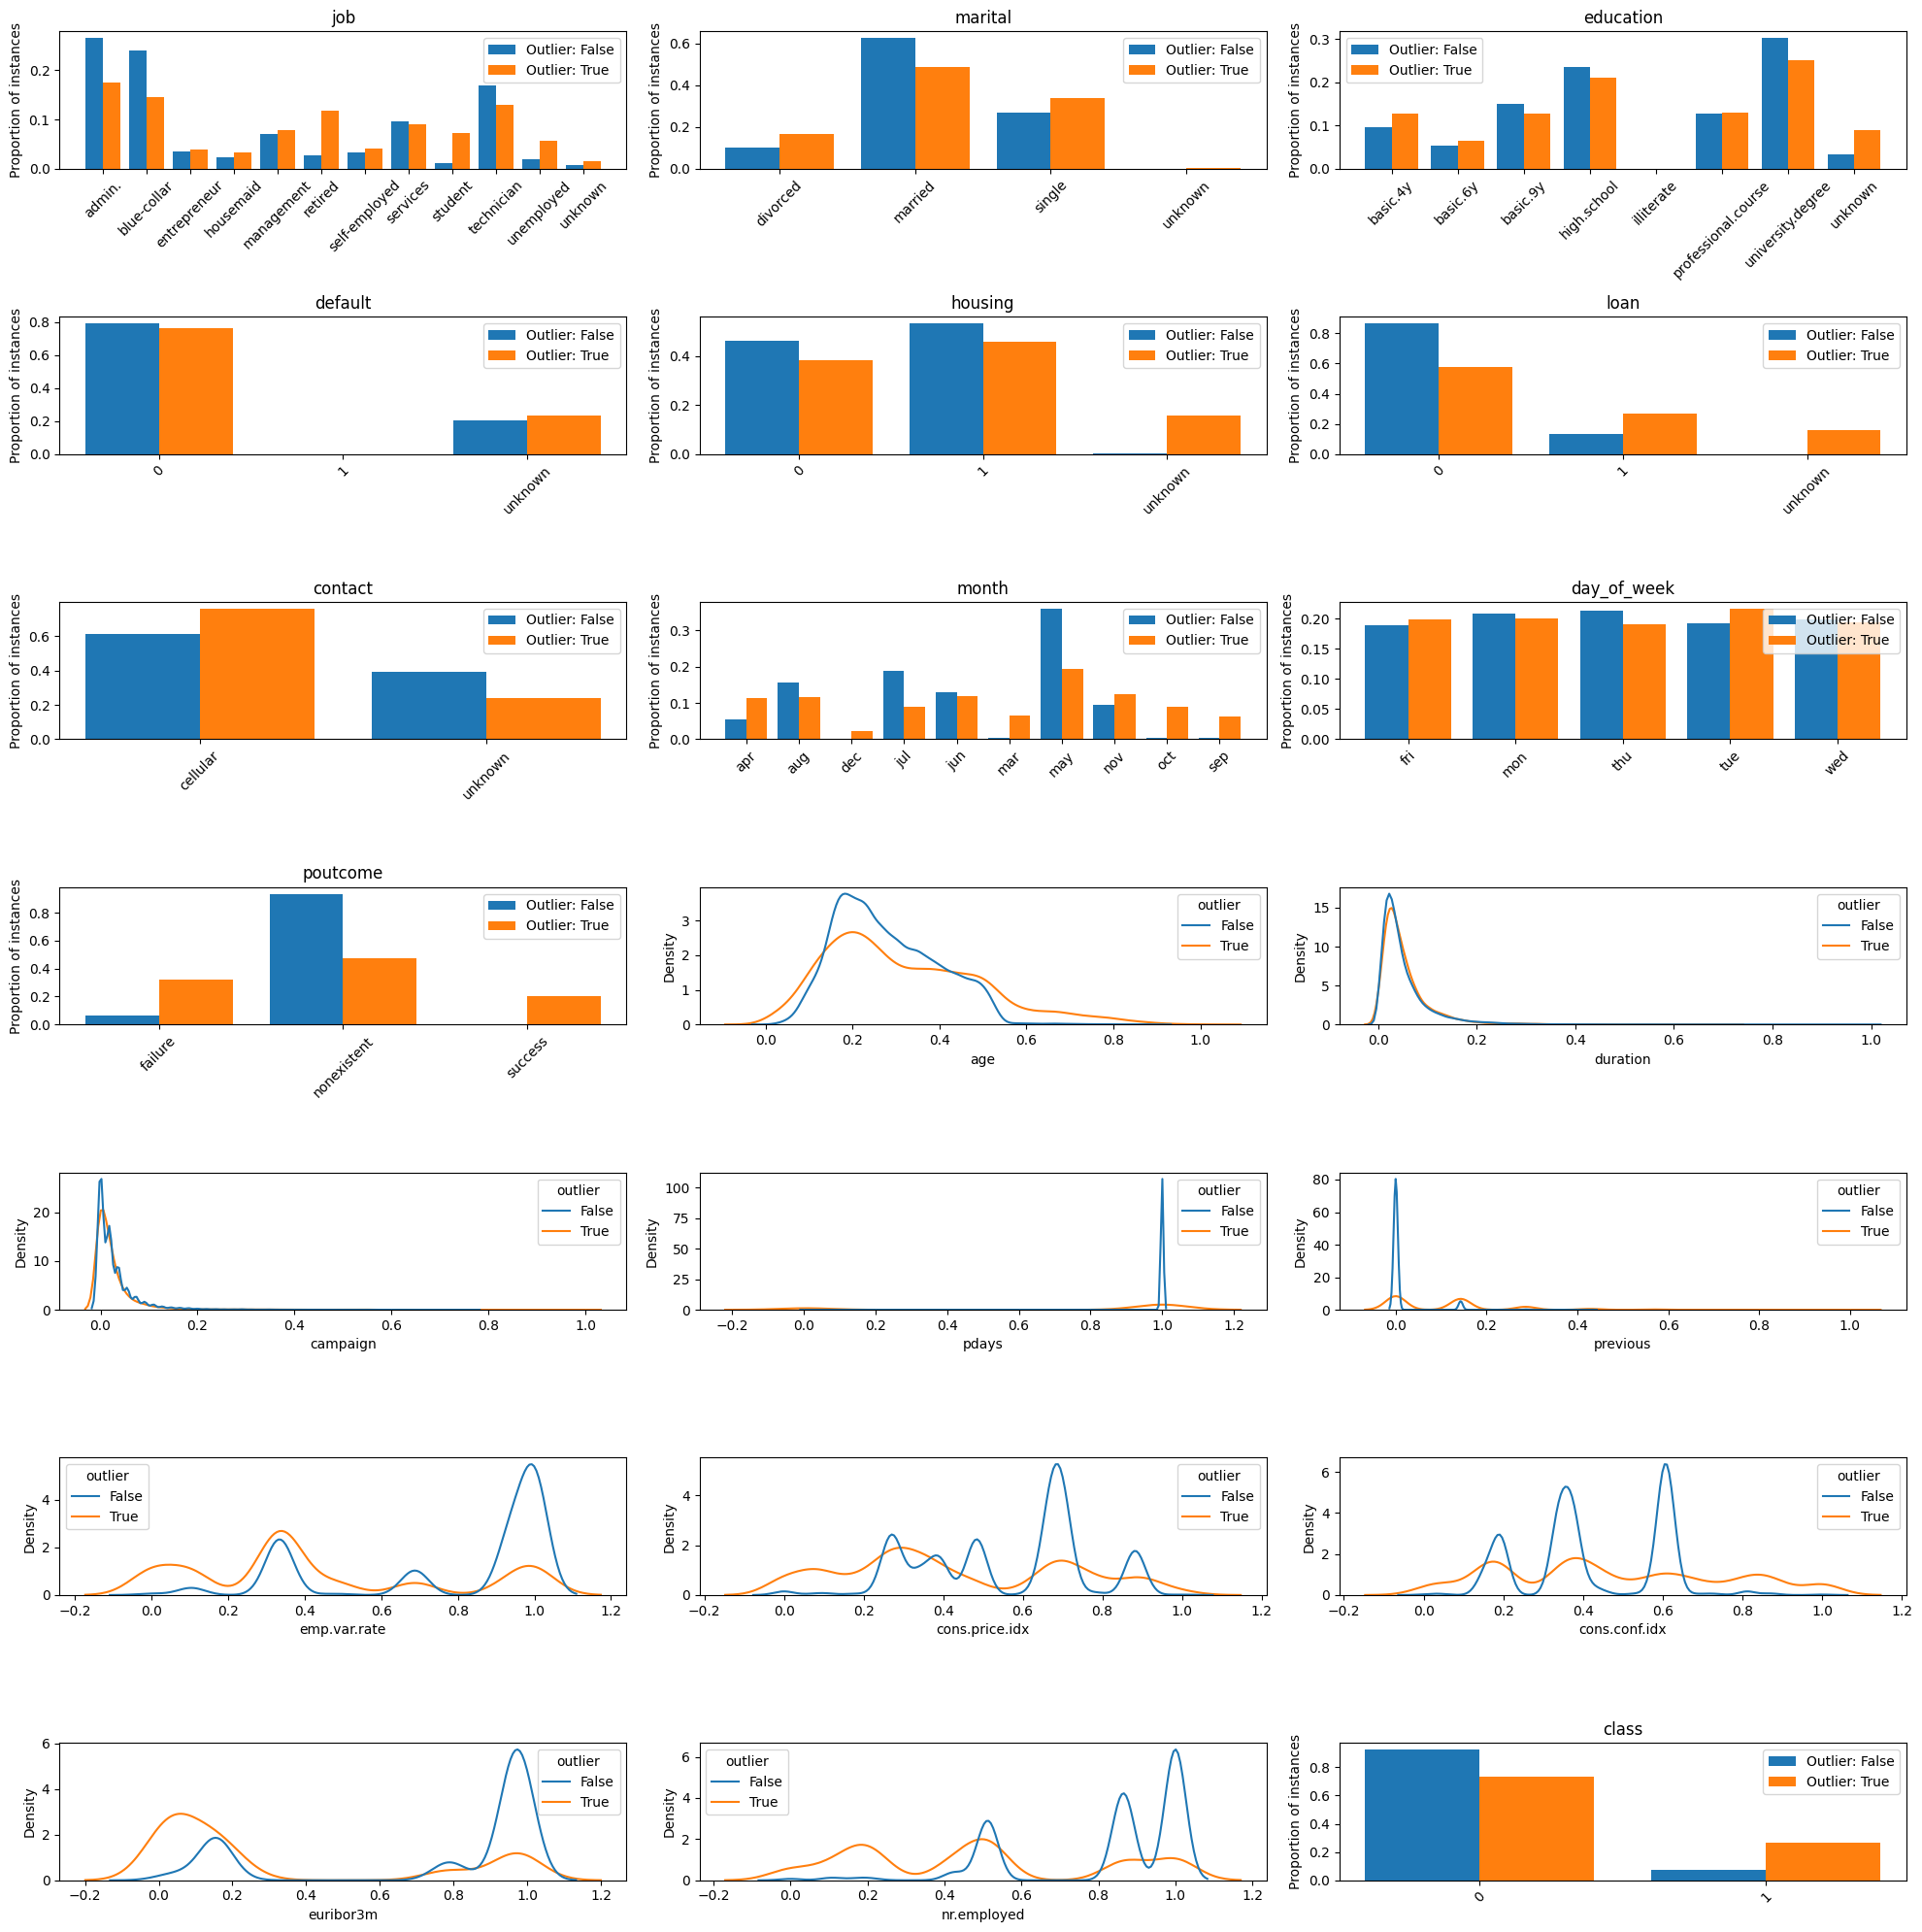

In [27]:
one_hot_decoded_data["outlier"] = data["outlier"].apply(bool)

bar_width = 0.4
n_groups = len(one_hot_decoded_data["outlier"].unique())
fig, axes = plt.subplots(7, 3, figsize=(20, 20))
cols_to_plot = [c for c in one_hot_decoded_data.columns if c != "outlier"]
for col, ax in zip(cols_to_plot, axes.flatten()):
    if col in categories or one_hot_decoded_data[col].dtype is np.dtype("int"):
        unique_values = sorted(one_hot_decoded_data[col].dropna().unique())
        index = np.arange(len(unique_values))

        for i, outlier_value in enumerate(one_hot_decoded_data["outlier"].unique()):
            filtered_data = one_hot_decoded_data[
                one_hot_decoded_data["outlier"] == outlier_value
            ]
            counts = filtered_data[col].value_counts(normalize=True)
            ax.bar(
                index + i * bar_width,
                counts.reindex(unique_values, fill_value=0),
                width=bar_width,
                label=f"Outlier: {outlier_value}",
            )

        ax.set_ylabel("Proportion of instances")
        ax.set_xticks(index + bar_width * (n_groups - 1) / 2)
        ax.set_xticklabels(unique_values, rotation=45)
        ax.set_title(col)
        ax.legend()

    elif col in numeric_columns:
        sns.kdeplot(
            data=one_hot_decoded_data, x=col, hue="outlier", ax=ax, common_norm=False
        )

fig.tight_layout()
plt.show()

## Task 5. Report your results and discuss your findings

### 5.1 Compare the performances

By now, you have applied three algorithms with different parameters on the data set. For each algorithm, you have create tables or figures which you can add to your report. Discuss the results and their optimal performance.

Create an overview table or figure that show the optimal performance of each algorithm on the data set, for example see the table here below.

Discuss your findings in the report and reflect on the following questions:
- According to the performance results, which one is the optimal model?
- How large is the difference between the accuracy score and the F1 score for each model? What caused the difference?
- Which of performance measures (the accuracy score, recall, precision, or F1-score) would you use for comparing the model performance? Why?
- You are comparing the performance of supervised algorithms (DT and RF) with an unsupervised algorithm (Isolation Forest). Is this a fair comparison? Motivate your answer.



| Model | Validation Accuracy  | Test Accuracy |  Validation Recall  |  Test Recall  | Validation F1 | Test F1 |... |
|------|------|------|------|------|------|------|-----|
|   Decision Tree        |  |  | | | | |
|   Random Forest  |  |  | || | |
|   Isolation Forest        |  |  | || | |



In [28]:
def print_performance_metrics(y_true, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred), "\n")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2}")
    print(f"Recall: {recall_score(y_true, y_pred):.2}")
    print(f"Precision: {precision_score(y_true, y_pred):.2}")
    print(f"F1: {f1_score(y_true, y_pred):.2}")

# best decision tree
print("==== DECISION TREE ====")
best_dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=16, random_state=RANDOM_SEED)
best_dt.fit(X_, y_)
y_test  = best_dt.predict(X_)
y_val = best_dt.predict(X_heldout)

print("---- validation ----")
print_performance_metrics(y_heldout, y_val)

print("---- test ----")
print_performance_metrics(y_, y_test)

# best random forest
print("==== RANDOM FOREST ====")
best_rf = RandomForestClassifier(max_features=10, n_estimators=140, random_state=RANDOM_SEED)
best_rf.fit(X_, np.ravel(y_))
y_test  = best_rf.predict(X_)
y_val = best_rf.predict(X_heldout)

print("---- validation ----")
print_performance_metrics(y_heldout, y_val)

print("---- test ----")
print_performance_metrics(y_, y_test)

# best isolation forest
print("==== ISOLATION FOREST ====")
best_if = IsolationForest(contamination=0.15000000000000002, max_samples=2100, random_state=RANDOM_SEED)
best_if.fit(X_)
y_test  = best_if.predict(X_)
y_test[y_test == 1] = 0
y_test[y_test == -1] = 1

y_val  = best_if.predict(X_heldout)
y_val[y_val == 1] = 0
y_val[y_val == -1] = 1

print("---- validation ----")
print_performance_metrics(y_heldout, y_val)

print("---- test ----")
print_performance_metrics(y_, y_test)

==== DECISION TREE ====
---- validation ----
Confusion Matrix:
 [[7110  107]
 [ 629  192]] 

Accuracy: 0.91
Recall: 0.23
Precision: 0.64
F1: 0.34
---- test ----
Confusion Matrix:
 [[28488   343]
 [ 2486   833]] 

Accuracy: 0.91
Recall: 0.25
Precision: 0.71
F1: 0.37
==== RANDOM FOREST ====
---- validation ----
Confusion Matrix:
 [[7015  202]
 [ 584  237]] 

Accuracy: 0.9
Recall: 0.29
Precision: 0.54
F1: 0.38
---- test ----
Confusion Matrix:
 [[28804    27]
 [  121  3198]] 

Accuracy: 1.0
Recall: 0.96
Precision: 0.99
F1: 0.98
==== ISOLATION FOREST ====
---- validation ----
Confusion Matrix:
 [[6285  932]
 [ 490  331]] 

Accuracy: 0.82
Recall: 0.4
Precision: 0.26
F1: 0.32
---- test ----
Confusion Matrix:
 [[25216  3615]
 [ 2111  1208]] 

Accuracy: 0.82
Recall: 0.36
Precision: 0.25
F1: 0.3


### 5.2 Analyze and discuss the results

For each optimal model, enrich your test set by adding the predicted labels by this model to the test set. Can you think of an analysis that gives insights into when the model performs poorly?

Discuss the analysis and insights in the report

## Bonus Tasks

We would like to challenge you with the following bonus tasks. For each task that is successfully completed, you may obtain max. 0.5 extra point.

### Bonus Task 1

Implement another outlier detection algorithm (for example, LOF, OC-SVM) or design your own outlier detection algorithm that achieves a better F1 score.




In [29]:
from sklearn.neural_network import MLPClassifier
# set parameter space
parameter_choices = [
    {'activation':activation, 'solver':solver, 'layer1':layer1, 'layer2':layer2}
    for activation in ["identity", "logistic", "tanh", "relu"]
    for solver in ["lbfgs", "sgd", "adam"]
    for layer2 in range(1, 6)
    for layer1 in range(2, 6)
]

max_f1 = 0
for parameter in parameter_choices:
    activation = parameter["activation"]
    layer1 = parameter["layer1"]
    layer2 = parameter["layer2"]
    solver = parameter["solver"]

    mlp = MLPClassifier(solver=solver, alpha=1e-5, hidden_layer_sizes=(layer1, layer2), activation=activation, max_iter=3000,  random_state=RANDOM_SEED)
    y_pred = mlp.fit(X_, np.ravel(y_)).predict(X_heldout)

    curr_f1 = f1_score(y_heldout, y_pred)
    if (curr_f1 > max_f1):
        max_f1 = curr_f1
        best = {
            "parameter": parameter,
            "cMatrix"  : confusion_matrix(y_heldout, y_pred),
            "accuracy" : accuracy_score(y_heldout, y_pred),
            "recall"   : recall_score(y_heldout, y_pred),
            "precision": precision_score(y_heldout, y_pred),
            "f1"       : curr_f1
        }

parameter = best["parameter"]
cMatrix = best["cMatrix"]
accuracy = best["accuracy"]
recall = best["recall"]
precision = best["precision"]
f1 = best["f1"]

print(f" ======= {parameter} =======")
print("Confusion Matrix:\n", cMatrix, "\n")

print(f"Accuracy: {accuracy:.2}")
print(f"Recall: {recall:.2}")
print(f"Precision: {precision:.2}")
print(f"F1: {f1:.2}")

 ======= {'activation': 'relu', 'solver': 'lbfgs', 'layer1': 4, 'layer2': 3} =======
Confusion Matrix:
 [[7032  185]
 [ 557  264]] 

Accuracy: 0.91
Recall: 0.32
Precision: 0.59
F1: 0.42


In [30]:
from sklearn.ensemble import AdaBoostClassifier
# set parameter space
parameter_choices = [
    {'learning_rate':learning_rate / 100, 'n_estimators': n_estimators, 'algorithm':algorithm}
    for algorithm in ["SAMME", "SAMME.R"]
    for learning_rate in range(1, 200, 10)
    for n_estimators in  range(5, 50, 5)
]

max_f1 = 0
best = None
for parameter in parameter_choices:
    learning_rate = parameter["learning_rate"]
    n_estimators = parameter["n_estimators"]
    algorithm = parameter["algorithm"]
    adaBoost = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm, random_state=RANDOM_SEED)
    y_pred = adaBoost.fit(X_, np.ravel(y_)).predict(X_heldout)

    curr_f1 = f1_score(y_heldout, y_pred)
    if (curr_f1 > max_f1):
        max_f1 = curr_f1
        best = {
            "parameter": parameter,
            "cMatrix"  : confusion_matrix(y_heldout, y_pred),
            "accuracy" : accuracy_score(y_heldout, y_pred),
            "recall"   : recall_score(y_heldout, y_pred),
            "precision": precision_score(y_heldout, y_pred),
            "f1"       : curr_f1
        }

parameter = best["parameter"]
cMatrix = best["cMatrix"]
accuracy = best["accuracy"]
recall = best["recall"]
precision = best["precision"]
f1 = best["f1"]

print(f" ======= {parameter} =======")
print("Confusion Matrix:\n", cMatrix, "\n")

print(f"Accuracy: {accuracy:.2}")
print(f"Recall: {recall:.2}")
print(f"Precision: {precision:.2}")
print(f"F1: {f1:.2}")

 ======= {'learning_rate': 1.61, 'n_estimators': 5, 'algorithm': 'SAMME'} =======
Confusion Matrix:
 [[6692  525]
 [ 419  402]] 

Accuracy: 0.88
Recall: 0.49
Precision: 0.43
F1: 0.46


### Bonus Task 2

Implement techniques (e.g., preprocessing, feature engineering, sampling) that help improve the F1 scores of existing models


In [34]:
df = data.copy()
df = df.loc[
    (df["job=unknown"] == 0)
    & (df["marital=unknown"] == 0)
    & (df["education=unknown"] == 0)
    & (df["default=unknown"] == 0)
    & (df["housing=unknown"] == 0)
    & (df["loan=unknown"] == 0)
]



# create X and y
selected_features = ["age", "job=housemaid", "job=services", "job=admin.", "job=blue-collar",
       "job=technician", "job=retired", "job=management", "job=unemployed",
       "job=self-employed", "job=entrepreneur", "job=student",
       "marital=married", "marital=single", "marital=divorced",
       "education=basic.4y", "education=high.school",
       "education=basic.6y", "education=basic.9y",
       "education=professional.course",
       "education=university.degree", "education=illiterate", "default=0",
       "default=1", "housing=0", "housing=1",
       "loan=0", "loan=1",
       "contact=cellular", "month=may", "month=jun", "month=jul", "month=aug",
       "month=oct", "month=nov", "month=dec", "month=mar", "month=apr",
       "month=sep", "day_of_week=mon", "day_of_week=tue", "day_of_week=wed",
       "day_of_week=thu", "day_of_week=fri", "campaign", "pdays",
       "previous", "poutcome=nonexistent", "poutcome=failure",
       "poutcome=success", "emp.var.rate", "cons.price.idx", "cons.conf.idx",
       "euribor3m", "nr.employed"]


X = df[selected_features]
y = df[["class"]]


# TODO: create training data and held-out test data
X_, X_heldout, y_, y_heldout = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

### Prediction Challenge

- Import the independent test set without labels, apply your best performing model on this test set.

- Enrich the test set with the predicted labels (**name this column 'predictedClass'**)

- Export both the model as pkl file and the enriched test data set as a csv file.

- The top three teams that have achieved the best accuracy score wins max. 0.3 bonus points.




In [46]:
import pickle

# import data
data_challenge = pd.read_csv("../data/dataBank-new_test_nolabel.csv", sep=",")
X_new = data_challenge[features]
print(X_new.describe())


# TODO: assign optimal model
learning_rate = parameter["learning_rate"]
n_estimators = parameter["n_estimators"]
algorithm = parameter["algorithm"]
adaBoost = AdaBoostClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    algorithm=algorithm,
    random_state=RANDOM_SEED,
)

optimal_model = adaBoost
optimal_model.fit(data[features], data["class"])

yhat = optimal_model.predict(X_new)

# TODO: enrich the data with the predicted labels by adding the column 'predictedClass'
X_new["predictedClass"] = yhat


# TODO: export the enriched data to disk

# export the model to disk
modelfilename = "Team_2_optimal_model.sav"
pickle.dump(optimal_model, open(modelfilename, "wb"))

               age  job=housemaid  job=services   job=admin.  job=blue-collar  \
count  1000.000000    1000.000000   1000.000000  1000.000000      1000.000000   
mean      0.290494       0.030000      0.108000     0.283000         0.175000   
std       0.154721       0.170673      0.310536     0.450682         0.380157   
min       0.000000       0.000000      0.000000     0.000000         0.000000   
25%       0.172840       0.000000      0.000000     0.000000         0.000000   
50%       0.246914       0.000000      0.000000     0.000000         0.000000   
75%       0.382716       0.000000      0.000000     1.000000         0.000000   
max       1.000000       1.000000      1.000000     1.000000         1.000000   

       job=technician  job=retired  job=management  job=unemployed  \
count     1000.000000  1000.000000     1000.000000     1000.000000   
mean         0.147000     0.072000        0.063000        0.027000   
std          0.354283     0.258617        0.243085        0.